In [1]:
import os
from os.path import join
import glob
import re

import pandas as pd
import ants
import numpy as np
from scipy import ndimage


In [2]:
def find_regions(lesions_mask, atlas, df_labels, list_tgt_labels):
    """
    Find regions in the atlas where lesions are located and order them from top to bottom.

    Parameters:
        lesions_mask (numpy array): Binary mask indicating lesion locations.
        atlas (numpy array): An atlas defining regions.
        df_labels (pandas DataFrame): DataFrame containing region labels.
        list_tgt_labels (list): List of target region labels.

    Returns:
        orders (list): Ordered list of lesion orders.
        regions (list): Corresponding regions where lesions are located.
    """
    # Generate a binary structure to use for labeling connected components
    struct_el = ndimage.generate_binary_structure(rank=3, connectivity=2)
    
    # Label connected components in the lesions mask
    mask_multi, n_les = ndimage.label(lesions_mask, structure=struct_el) 
    orders = []
    regions = []
    
    for l in range(n_les):
        np_l = mask_multi == l + 1  # Extract each lesion one by one
        order = l + 1
        
        # Create a mask to filter out non-target regions from the atlas
        mask = np.isin(atlas, list_tgt_labels)
        atlas_tgt_regions = atlas * mask

        # Get labels of regions overlapped by the current lesion
        labels_overlap = np.asarray(atlas[np_l], dtype=int)
        list_labels_overlap = list(labels_overlap)
        
        # Filter out non-target regions
        list_labels_overlap = [x for x in list_labels_overlap if x in list_tgt_labels]

        if len(list_labels_overlap) == 0:
            # If no overlap with target regions, find the closest one
            label = find_closest_label(np_l, atlas_tgt_regions)
            region = df_labels.loc[df_labels['id'] == label, 'fullname'].values[0]
            print("(No overlap with target regions)")
        else:
            # Determine the most frequent label among the overlapping regions
            label = np.bincount(list_labels_overlap).argmax()
            region = df_labels.loc[df_labels['id'] == label, 'fullname'].values[0]

        print(f"{order:02d} {region} ({label}), overlaps with: {np.unique(labels_overlap)}")

        orders.append(order)
        regions.append(region)
        
    return orders, regions

def find_closest_label(lesion_mask, labels):
    """
    Find the closest label in the 'labels' array to the connected component represented by the boolean 'lesion_mask'.

    Parameters:
        lesion_mask (numpy array): Boolean numpy array representing a single connected component.
        labels (numpy array): Numpy array with different labels (different int values).

    Returns:
        closest_label (int): The label of the closest label in 'labels' to 'lesion_mask'.
    """
    # Calculate the distance to the nearest True pixel for each pixel in 'lesion_mask'
    distances = ndimage.distance_transform_cdt(~lesion_mask)

    # Find the label in 'labels' that is closest to 'lesion_mask'
    unique_labels = np.unique(labels)
    closest_label = int(unique_labels[np.argmin([np.mean(distances[labels == label]) for label in unique_labels])])

    return closest_label

In [ ]:
# For predictions
data_path = "/home/vincent/repos/brain-mets/data/nnUNet_raw_data_base/nnUNet_raw_data/Task502_BrainMetsReseg1to1nodnecFIX"

# im_t1 = ants.image_read("/home/vincent/repos/brain-mets/data/nnUNet_raw_data_base/nnUNet_raw_data/Task502_BrainMetsReseg1to1nodnec/imagesTs/TARGET_132_0000.nii.gz")
# im_t1 = ants.image_read("/home/vincent/repos/brain-mets/data/nnUNet_raw_data_base/nnUNet_raw_data/Task502_BrainMetsReseg1to1nodnec/imagesTs/TARGET_135_0000.nii.gz")
im_t1 = ants.image_read("/home/vincent/repos/brain-mets/data/nnUNet_raw_data_base/nnUNet_raw_data/Task502_BrainMetsReseg1to1nodnecFIX/imagesTs/TARGET_133_0000.nii.gz")
# im_brain = ants.image_read("/mnt/nas4/datasets/ToReadme/Target/BIDS_MRI_Target_subset/sub-PAT070/ses-20150626090737/anat/sub-PAT070_ses-20150626090737_acq-t1mpragesagGDND_run-1_T1w_bet_mask.nii.gz")
# im_brain = ants.image_read("/mnt/nas4/datasets/ToReadme/Target/BIDS_MRI_Target_subset/sub-PAT073/ses-20150811133648/anat/sub-PAT073_ses-20150811133648_acq-t1mpragesagGDND_run-1_T1w_bet_mask.nii.gz")
im_brain = ants.image_read("/mnt/nas4/datasets/ToReadme/Target/BIDS_MRI_Target_subset/sub-PAT070/ses-20150626090737/anat/sub-PAT070_ses-20150626090737_acq-t1mpragesagGDND_run-1_T1w_bet_mask.nii.gz")
im_t1 = im_t1*im_brain
im_t1 = ants.resample_image(im_t1,(1.,1.,1.),interp_type=4)
# im_pred = ants.image_read("/home/vincent/repos/brain-mets/data/nnUNet_raw_data_base/nnUNet_raw_data/Task502_BrainMetsReseg1to1nodnec/predsTs/TARGET_132.nii.gz")
# im_pred = ants.image_read("/home/vincent/repos/brain-mets/data/nnUNet_raw_data_base/nnUNet_raw_data/Task502_BrainMetsReseg1to1nodnec/predsTs/TARGET_135.nii.gz")

im_pred = ants.image_read("/home/vincent/repos/brain-mets/data/nnUNet_raw_data_base/nnUNet_raw_data/Task502_BrainMetsReseg1to1nodnecFIX/labelsTs/TARGET_133.nii.gz")
im_pred = ants.resample_image_to_target(im_pred,im_t1)
path_atlas = "/mnt/nas4/datasets/ToReadme/USCLobes/"
im_t1atlas = ants.image_read(join(path_atlas,"BCI-DNI_brain.bfc.nii.gz"))
# im_t1atlas = ants.image_read(join(path_atlas,"BCI-DNI_brain.nii.gz"))
im_atlas = ants.image_read(join(path_atlas,"BCI-DNI_brain.label.nii.gz"))
df_labels = pd.read_xml(join(path_atlas,"brainsuite_labeldescription.xml"))
df_labels = df_labels[df_labels['id'].isin(np.unique(im_atlas.numpy()))]


In [7]:
df_labels.head(5)

,id,tag,color,fullname
0,0,bkg,0x0,background
3,3,WM,0xffffff,white matter
15,100,FL,0x952e91,R. Frontal Lobe
16,101,FL,0xf238f0,L. Frontal Lobe
51,184,CgG,0xffa852,R. cingulate gyrus


In [8]:
np.unique(im_atlas.numpy())

array([  0.,   3., 100., 101., 184., 185., 200., 201., 300., 301., 400.,
       401., 500., 501., 800., 850., 900., 950.], dtype=float32)

In [9]:
# Add skull strip:
# in repos/HD-BET, now broken, to fix:
# hd-bet -i "/home/vincent/repos/brain-mets/data/nnUNet_raw_data_base/nnUNet_raw_data/Task502_BrainMetsReseg1to1nodnec/imagesTs/TARGET_132_0000.nii.gz" -o /home/vincent/repos/brain-mets/data/brain_ma

In [10]:
# Fixed image for registration: atlas so that we get a common alignement. 
# But the Target naming is made on the orientation of the MRI...
# Set the origin to be closer in space.

im_t1.set_origin(ants.get_origin(im_t1atlas))

print(im_t1atlas.spacing, im_t1.spacing, im_t1atlas.origin, im_t1.origin)

im_t1atlas = ants.resample_image_to_target(im_t1atlas,im_t1)
im_atlas = ants.resample_image_to_target(im_atlas,im_t1,"nearestNeighbor")

print(im_t1atlas.spacing, im_t1.spacing, im_t1atlas.origin, im_t1.origin)

# Split some regions in L/R: use the hemi.label from the USC atlas (even numbers=left, odd=right)
im_hemis = ants.image_read(join(path_atlas,"BCI-DNI_brain.hemi.label.nii.gz"))
# im_hemis.set_origin(ants.get_origin(im_t1))
im_hemis = ants.resample_image_to_target(im_hemis,im_t1)
np_hemis = im_hemis.numpy()
np_atlas = im_atlas.numpy()
# print(np_atlas.shape, np_hemis.shape, np.unique(np_hemis))
np_hemisL = np.where(np_hemis == 0, 0, np.where(np_hemis % 2 == 0, 1, 0))
np_hemisR = np.where(np_hemis % 2 != 0, 1,  0)
# print(np_atlas.shape, np_hemisL.shape, np.unique(np_hemisL),np.unique(np_hemisR))

list_splitLR = [3,800,850,900]
for v in list_splitLR:
    np_atlas = np.where(np_atlas == v, np.where(np_hemisR==1,v,v+1), np_atlas)
    new_row = pd.DataFrame({'id': [v + 1], 'fullname': ['L. ' + df_labels[df_labels['id'] == v]['fullname'].values[0]]})
    df_labels.loc[df_labels['id'] == v, 'fullname'] = 'R. ' + df_labels[df_labels['id'] == v]['fullname'].values[0]
    df_labels = pd.concat([df_labels, new_row], ignore_index=True)
im_atlas = ants.from_numpy(np_atlas, origin=im_atlas.origin, spacing=im_atlas.spacing, direction=im_atlas.direction)
df_labels = df_labels.sort_values(by=['id'])
print(df_labels)


(0.800000011920929, 0.546875, 0.546875) (1.0, 1.0, 1.0) (0.0, 0.0, 0.0) (0.0, 0.0, 0.0)
(1.0, 1.0, 1.0) (1.0, 1.0, 1.0) (0.0, 0.0, 0.0) (0.0, 0.0, 0.0)
     id  tag     color            fullname
0     0  bkg       0x0          background
1     3   WM  0xffffff     R. white matter
17    4  NaN       NaN     L. white matter
2   100   FL  0x952e91     R. Frontal Lobe
3   101   FL  0xf238f0     L. Frontal Lobe
4   184  CgG  0xffa852  R. cingulate gyrus
5   185  CgG  0xeb9a85  L. cingulate gyrus
6   200   PL  0x75ec3d    R. Parietal Lobe
7   201   PL  0xabf231    L. Parietal Lobe
8   300   TL  0x3284ec    R. Temporal Lobe
9   301   TL  0x5deff2    L. Temporal Lobe
10  400   OL  0xfffc7a   R. Occipital Lobe
11  401   OL  0xf2e12a   L. Occipital Lobe
12  500  Ins  0xff3ebe           R. Insula
13  501  Ins  0xa800a7           L. Insula
14  800  BSt  0x7f007f        R. Brainstem
18  801  NaN       NaN        L. Brainstem
15  850   cc  0xff0000  R. Corpus Callosum
19  851  NaN       NaN  L. Corp

In [11]:
# Register images and apply transforms
reg = ants.registration(im_t1atlas, im_t1, 'Affine') # Affine, SyNCC
im_t1_reg = reg['warpedmovout']
im_pred_reg = ants.apply_transforms(fixed = im_t1atlas, moving = im_pred, transformlist = reg['fwdtransforms'], interpolator  = 'nearestNeighbor')
np_pred_reg = im_pred_reg.numpy()

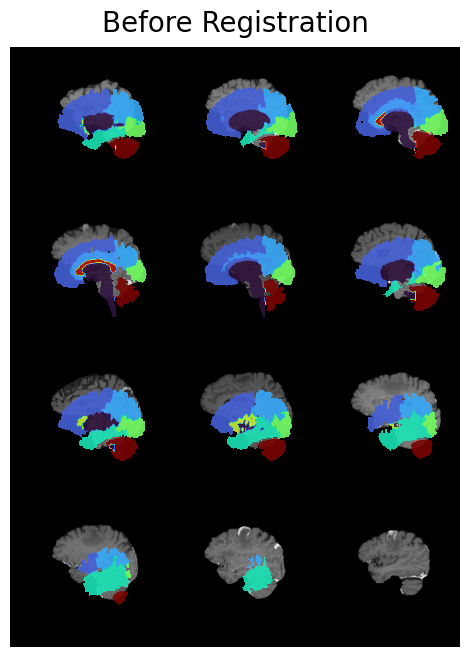

In [12]:
im_t1.plot(overlay=im_atlas, title='Before Registration')

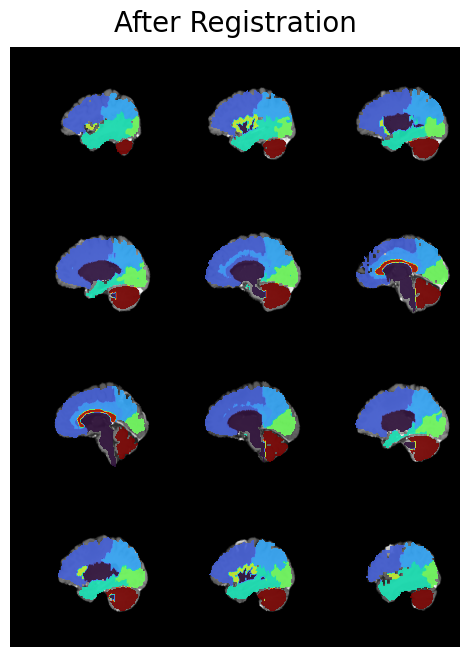

In [13]:

im_t1_reg.plot(overlay=im_atlas,title='After Registration')


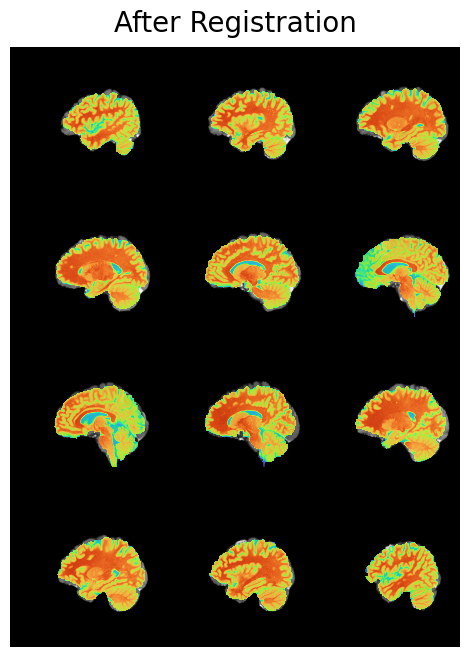

In [14]:
im_t1_reg.plot(overlay=im_t1atlas,title='After Registration')


In [ ]:
# Check that all images are correctly registered:
# I need the mapping to find the pat and ses
mapping_target_path = "/home/vincent/repos/brain-mets/data/nnUNet_mapping/mapping_Task502_BrainMetsReseg1to1nodnec.csv"
mapping_target = pd.read_csv(mapping_target_path)

data_path = "/home/vincent/repos/brain-mets/data/nnUNet_raw_data_base/nnUNet_raw_data/Task502_BrainMetsReseg1to1nodnecFIX/"

pattern = r"TARGET_(\d+)_"
list_tgt_regions = ['R. Frontal Lobe','L. Frontal Lobe','R. Parietal Lobe','L. Parietal Lobe',
                    'R. Temporal Lobe','L. Temporal Lobe','R. Occipital Lobe','L. Occipital Lobe',
                    'R. Brainstem', 'L. Brainstem']

im_atlas.to_file("/home/vincent/repos/brain-mets/notebooks/images/radiomics/atlas.nii.gz")

tr_path = join(data_path,'imagesTr')
ts_path = join(data_path,'imagesTs')
for folder_path in [tr_path, ts_path]:
    split = folder_path[-2:]
    for t1_file in sorted(os.listdir(folder_path)):
        if "_0001." in t1_file:
            continue
        tgt = int(re.search(pattern, t1_file).group(1))
        pat = mapping_target.loc[mapping_target['Idx']==tgt]['Patient'].values[0]
        ses = mapping_target.loc[mapping_target['Idx']==tgt]['Session'].values[0]
        brain_path = f"/mnt/nas4/datasets/ToReadme/Target/BIDS_MRI_Target_subset/sub-{pat}/ses-{ses}*/anat/*bet_mask.nii.gz"
        im_t1 = ants.image_read(join(folder_path,t1_file))
        # im_pred = ants.image_read(f"/home/vincent/repos/brain-mets/data/nnUNet_raw_data_base/nnUNet_raw_data/Task502_BrainMetsReseg1to1nodnec/preds{split}/TARGET_{tgt:03d}.nii.gz")
        # im_pred = ants.resample_image_to_target(im_pred,im_t1)
        im_gt = ants.image_read(f"/home/vincent/repos/brain-mets/data/nnUNet_raw_data_base/nnUNet_raw_data/Task502_BrainMetsReseg1to1nodnecFIX/labels{split}/TARGET_{tgt:03d}.nii.gz")
        im_gt = ants.resample_image_to_target(im_gt,im_t1)
        im_t1 = im_t1 * ants.image_read(glob.glob(brain_path)[0])
        im_t1 = ants.resample_image(im_t1,(1.,1.,1.),interp_type=4)
        im_t1.set_origin(ants.get_origin(im_t1atlas))
        im_gt.set_origin(ants.get_origin(im_t1atlas))
        reg = ants.registration(im_t1atlas, im_t1, 'Affine') # Affine, SyNCC
        im_t1_reg = reg['warpedmovout']

        # Apply transforms and find regions
        im_gt_reg = ants.apply_transforms(fixed = im_t1atlas, moving = im_gt, transformlist = reg['fwdtransforms'], interpolator  = 'nearestNeighbor')
        # Find the regions of all lesions
        print(tgt, pat, ses)
        orders, regions = find_regions(np.flip(np.transpose(im_gt_reg.numpy(),(2,1,0))), np.flip(np.transpose(np_atlas,(2,1,0))), df_labels, list_tgt_labels = [100, 101, 200, 201, 300, 301, 400, 401, 800, 801])

        if len(list(set(regions).difference(list_tgt_regions)))>0:
            print(list(set(regions).difference(list_tgt_regions)))

        # Save images to check: save the atlas once, then the aligned gts with tgt, pat, ses
        path = f"/home/vincent/repos/brain-mets/notebooks/images/radiomics/{tgt:03d}_{pat}_{ses}.nii.gz"
        im_gt_reg.to_file(path)


1 PAT003 20170622
01 R. Frontal Lobe (100), overlaps with: [  0 100 101 184 185]
